### Cleaning the Scraped Data

This notebook uses some of Samantha's code to load in the data.  

The main purpose of this notebook is to document the getUrls function, which goes through the `.json` file outputted from our webscraper `Diffbot`, and extracts the real estate listing urls from the json structure.

Each row of the output dataframe corresponds to a single image within a single housing listing. But the problem we ran into was that Diffbot did not return all the images that one could find in that single housing listing. So outside of this notebook, we needed to do further work to extract all the images.

In [1]:
# !pip install flat_table

In [15]:
import requests
from bs4 import BeautifulSoup
import html5lib

from skimage import io
import matplotlib.pyplot as plt

import json
from pandas import json_normalize
import flat_table # to "unravel" json to df tables

import pandas as pd
import numpy as np
import re

#### Loading in the Data

In [24]:
f = open("../data/bayarea-all-single-family-imageapi-vl.json")
data = json.load(f)

In [25]:
#https://www.realtor.com/realestateandhomes-search/BAY-AREA-CITY_CA/type-single-family-home where BAY-AREA-CITY is among
# the list of cities in the brainstorming document
df = json_normalize(data)
df[[col for col in df.columns if 'url' in col.lower()]]['pageUrl'][10]

'https://www.realtor.com/realestateandhomes-detail/1601-Arkell-Rd_Walnut-Creek_CA_94598_M20023-64409'

#### Looking at the columns in the Dataframe

In [26]:
# NULLS
for i, col in enumerate(df.columns): 
    print(i, col, np.count_nonzero(pd.isna(df[col])))

0 date 537
1 xpath 0
2 humanLanguage 0
3 naturalHeight 5
4 diffbotUri 0
5 pageUrl 0
6 type 0
7 title 37
8 url 0
9 naturalWidth 141
10 tags 163
11 docId 0
12 fromSeedUrl 0
13 seedUrlHash32 0
14 parentUrlDocId 0
15 gburl 0
16 lastCrawlTimeUTC 0
17 timestamp 0
18 anchorUrl 336


In [95]:
# number of unique urls from a single webscrape from Diffbot using their image webscraping API
df['url'].unique().shape

(480,)

In [122]:
def getUrls(filename):
    '''
    Takes in a json file name including the path.
    Grabs all the unique urls from a Diffbot crawl of `realtor.com` using image API json file.
    Returns a Series with all the unique realtor urls.
    '''
    f = open(filename)
    data = json.load(f)
    df = json_normalize(data)
    urls = pd.Series(df['anchorUrl'].append(df['pageUrl']).unique())
    urls = urls[urls.notna() & urls.str.contains('https://www.realtor.com/realestateandhomes-detail/')]
    return urls

getUrls("../data/bayarea-all-single-family-imageapi-vl.json")

1      https://www.realtor.com/realestateandhomes-det...
2      https://www.realtor.com/realestateandhomes-det...
3      https://www.realtor.com/realestateandhomes-det...
4      https://www.realtor.com/realestateandhomes-det...
5      https://www.realtor.com/realestateandhomes-det...
                             ...                        
264    https://www.realtor.com/realestateandhomes-det...
266    https://www.realtor.com/realestateandhomes-det...
267    https://www.realtor.com/realestateandhomes-det...
273    https://www.realtor.com/realestateandhomes-det...
275    https://www.realtor.com/realestateandhomes-det...
Length: 251, dtype: object

#### Images

In [123]:
images = df.copy()
images = images[images.url.apply(lambda x: 'maps' not in x)] #get rid of google map images
images.shape

(446, 19)

In [124]:
# filter out logos and other non-house images by url
pattern = 'https:\/\/a[np].rdcpix.com'
images = images[images['url'].apply(lambda x: bool(re.match(pattern, x)))]

In [125]:
#convert image links to pixels, add as column, will prob take some time to complete
images['pixels'] = images.url.apply(lambda x: io.imread(x))

In [126]:
images.head(2) #sanity check; takes a long time to load the pixel column

,date,xpath,humanLanguage,naturalHeight,diffbotUri,pageUrl,type,title,url,naturalWidth,tags,docId,fromSeedUrl,seedUrlHash32,parentUrlDocId,gburl,lastCrawlTimeUTC,timestamp,anchorUrl,pixels
0,"Oct 16, 2020",/HTML/BODY/DIV[@class='page-content']/DIV[@cla...,en,681.0,image|3|-1587242008,https://www.realtor.com/realestateandhomes-det...,image,"646 Tamarack Dr, Union City, CA 94587",https://ap.rdcpix.com/060cb73160bc01770ed249a8...,1020.0,"[{'score': 0.98, 'count': 1, 'label': 'Tamarac...",103631138971,https://www.realtor.com/realestateandhomes-sea...,1077127705,63311163577,https://www.realtor.com/realestateandhomes-det...,1603045580,"Sun, 18 Oct 2020 18:26:20 GMT",NaN,"[[[255, 255, 255], [237, 237, 237], [241, 241,..."
1,NaN,/HTML/BODY/DIV[@class='page-content']/DIV[@cla...,en,681.0,image|3|-27982848,https://www.realtor.com/realestateandhomes-det...,image,"646 Tamarack Dr, Union City, CA 94587",https://ap.rdcpix.com/060cb73160bc01770ed249a8...,1020.0,"[{'score': 0.98, 'count': 1, 'label': 'Tamarac...",245493444779,https://www.realtor.com/realestateandhomes-sea...,1077127705,63311163577,https://www.realtor.com/realestateandhomes-det...,1603045580,"Sun, 18 Oct 2020 18:26:20 GMT",NaN,"[[[255, 255, 255], [237, 237, 237], [241, 241,..."


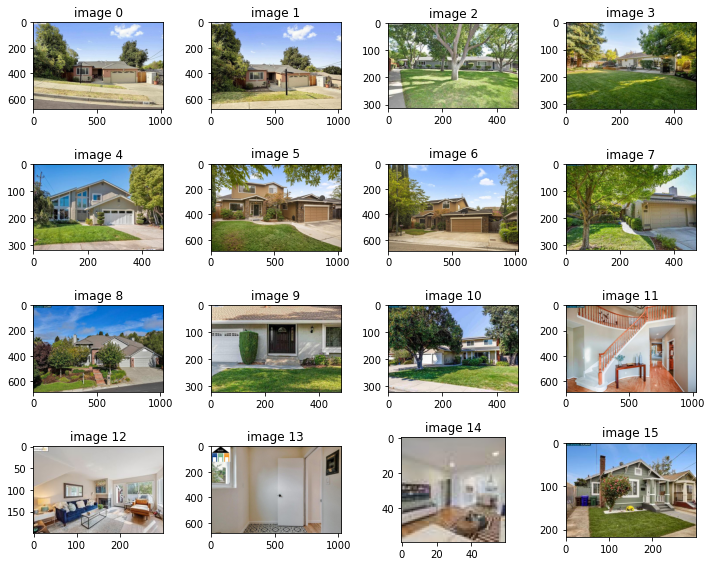

In [127]:
fig, ax = plt.subplots(4, 4, figsize=(10, 8))

row = 0
col = 0
for i in np.arange(16):
    ax[row, col].imshow(images.iloc[i]["pixels"], cmap="gray")
    ax[row, col].set_title('image {}'.format(i))
    col += 1
    if col >=4: 
        col = 0
        row += 1

plt.tight_layout()
